
## Задание 7

Обучить нейронную сеть для распознавания действий человека по видео на датасете KTH Библиотеки: [Python, Tensorflow]

In [1]:
!pip install scikit-video==1.1.11 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 31.8 MB/s 


In [2]:
import os
import cv2
import math
import glob
import scipy
import scipy.misc
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import skvideo.io

In [3]:
!wget http://www.csc.kth.se/cvap/actions/walking.zip
!wget http://www.csc.kth.se/cvap/actions/jogging.zip
!wget http://www.csc.kth.se/cvap/actions/running.zip
!wget http://www.csc.kth.se/cvap/actions/boxing.zip
!wget http://www.csc.kth.se/cvap/actions/handwaving.zip
!wget http://www.csc.kth.se/cvap/actions/handclapping.zip 

--2022-08-01 13:12:56--  http://www.csc.kth.se/cvap/actions/walking.zip
Resolving www.csc.kth.se (www.csc.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c29
Connecting to www.csc.kth.se (www.csc.kth.se)|130.237.28.41|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.csc.kth.se/cvap/actions/walking.zip [following]
--2022-08-01 13:12:57--  https://www.csc.kth.se/cvap/actions/walking.zip
Connecting to www.csc.kth.se (www.csc.kth.se)|130.237.28.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 242442411 (231M) [application/zip]
Saving to: ‘walking.zip’

walking.zip         100%[===================>] 231.21M   574KB/s    in 6m 51s  

2022-08-01 13:19:49 (576 KB/s) - ‘walking.zip’ saved [242442411/242442411]

URL transformed to HTTPS due to an HSTS policy
--2022-08-01 13:19:49--  https://www.csc.kth.se/cvap/actions/jogging.zip
Resolving www.csc.kth.se (www.csc.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c29

In [4]:
!unzip walking.zip -d walking > /dev/null
!unzip jogging.zip -d jogging > /dev/null
!unzip running.zip -d running > /dev/null
!unzip boxing.zip -d boxing > /dev/null
!unzip handwaving.zip -d handwaving > /dev/null
!unzip handclapping.zip -d handclapping > /dev/null

In [5]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

dataset = []
data_root = './'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
        cls_idx = classes.index(cls)
        dataset.append((fpath, cls_idx))

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping


### Разделим датасет на тренировочную и тестовую выборки.

In [6]:
random.shuffle(dataset)

test_count = math.floor(len(dataset)*0.4)

train_ds = dataset[:-test_count]
test_ds = dataset[-test_count:]

len(train_ds), len(test_ds)

(360, 239)

### Визуализация кадра видео

In [7]:
dataset[0][0]

'./handclapping/person24_handclapping_d3_uncomp.avi'

videodata shape: (402, 120, 160, 3)
videodata shape: (120, 160, 3)


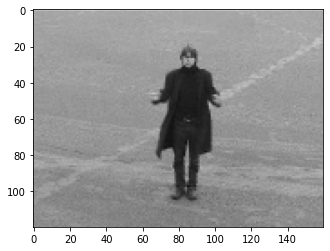

In [8]:
videodata = skvideo.io.vread(dataset[0][0]) 
videodata = videodata.astype(np.float32) / 255.
print('videodata shape:', videodata.shape)
print('videodata shape:', videodata[50, ...].shape)
plt.imshow(videodata[50, ...]) # берем 50-й кадр.

### Визуализация "движения"

motion shape: (134, 120, 160, 1)


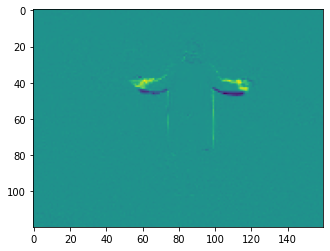

In [9]:
# Смещение изображения
motion = np.mean(videodata[0::3, ...] - videodata[1::3, ...], axis=3, keepdims=True)
print('motion shape:', motion.shape)
plt.imshow(motion[50, ..., 0])


### Создание модели CNN

In [10]:
model = tf.keras.Sequential([                                
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation=None),
])

In [11]:
inp = motion[None, ...]
out = model(inp)

print('Input shape:', inp.shape)
print('Output shape:', out.shape)

Input shape: (1, 134, 120, 160, 1)
Output shape: (1, 6)


### Подготовка к обучению

In [12]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))

writer = tf.summary.create_file_writer('logs/exp1')

In [13]:
def keras_generator(dataset, batch_size=1, frames=150, image_size=(80,60)):
    c = 0
    ind = np.arange(0, len(dataset))
    random.shuffle(ind)

    while True:
        X_batch = []
        y_batch = []
        for i in range(c, c + batch_size):

            img_path, label = dataset[i]
            videodata = skvideo.io.vread(img_path)
            videodata = videodata.astype(np.float32) / 255.
            # T, M, N, C = videodata.shape
            # steps = T//step
            step = 1
            steps = frames # для того чтобы видеоролики можно было объединить в batch. к-во кадров у них должно быть одинаковым.
            motion = []
            for s in range(steps):
                # if (s+4)*step > T:
                #     break
                frame_1 = cv2.resize(videodata[s*step], image_size)
                frame_2 = cv2.resize(videodata[(s+2)*step], image_size) # s+2 - это значить картинка смещена на два кадра.
                motion.append(np.mean((frame_1 - frame_2), axis=2, keepdims=True))

            X_batch.append(motion)
            y_batch.append(label)
            
        X_batch = np.array(X_batch, dtype='float')
        y_batch = np.array(y_batch, dtype='uint8')
        
        c += batch_size
        if(c + batch_size >= len(ind)):
            c = 0
            random.shuffle(ind)

        yield X_batch, y_batch

In [14]:
# создадим массив для проверки.
batch_size = 3
frames = 150 # видео объединяемые в батч должны иметь одинаковую продолжительность по кадрам.
target_img_size = (80,60) 

train_generator = keras_generator(train_ds, batch_size=batch_size,frames=frames, image_size=target_img_size)
test_generator = keras_generator(test_ds, batch_size=batch_size,frames=frames, image_size=target_img_size)

### Обучение модели

In [15]:
%%time
# global_step = 0
steps_per_epoch = len(train_ds)//batch_size
test_X, test_y = next(test_generator)
train_loss=[]
test_loss=[]

for epoch in range(NUM_EPOCHS):
    for iter in range(steps_per_epoch):

        train_X, train_y = next(train_generator)

        train_loss_value = model.train_on_batch(train_X, train_y)

        if iter % 10 == 0:
            test_loss_value = model.test_on_batch(test_X, test_y)

            test_loss.append(test_loss_value)
            train_loss.append(train_loss_value)

    print(f'[{epoch+1}/{NUM_EPOCHS}] loss: {train_loss_value}, val_loss: {test_loss_value}')

[1/10] loss: 0.08586271852254868, val_loss: 1.09110689163208
[2/10] loss: 0.5123974680900574, val_loss: 1.8324257135391235
[3/10] loss: 0.019390547648072243, val_loss: 5.321279525756836
[4/10] loss: 0.018614262342453003, val_loss: 8.59751033782959
[5/10] loss: 0.16624468564987183, val_loss: 11.29166030883789
[6/10] loss: 0.12630634009838104, val_loss: 14.603754997253418
[7/10] loss: 0.029110819101333618, val_loss: 9.995073318481445
[8/10] loss: 2.2895348072052, val_loss: 8.67967700958252
[9/10] loss: 0.06112389639019966, val_loss: 16.752389907836914
[10/10] loss: 0.06179441884160042, val_loss: 11.061327934265137
CPU times: user 6min 45s, sys: 4min 37s, total: 11min 22s
Wall time: 25min 14s


### Посторим график обучения

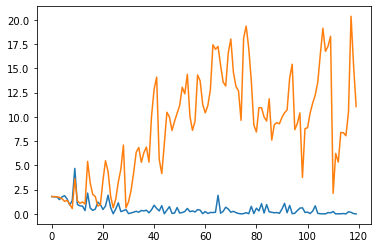

In [16]:
plt.plot(train_loss)
plt.plot(test_loss)
plt.show()

### Тестирование обученной модели

True class: running
Predicted class: running


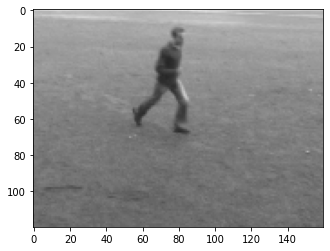

In [31]:
fpath, cls_true = random.choice(dataset)

videodata = skvideo.io.vread(fpath)
videodata = videodata.astype(np.float32) / 255.
plt.imshow(videodata[30, ...])

motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)

out = model(motion[None, ...])[0]
cls_pred = np.argmax(out.numpy())

print('True class:', classes[cls_true])
print('Predicted class:', classes[cls_pred])